In [1]:
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


In [2]:
import os
import pymatgen
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
structures = pd.read_pickle("datasets/structures_defects.pickle.gzip")

In [4]:
import matplotlib
import pylab

from megnet.models import MEGNetModel
from megnet.data.graph import GaussianDistance
from megnet.data.crystal import CrystalGraph
from megnet.data.molecule import MolecularGraph
from megnet.utils.preprocessing import StandardScaler
from megnet.callbacks import ModelCheckpointMAE
from pymatgen.core import Lattice, Structure, Molecule

import tensorflow as tf
import numpy as np

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train, test = train_test_split(structures, test_size=0.25, random_state=42)

In [8]:
print(train.shape, test.shape)

(2610, 10) (870, 10)


In [27]:
structures.head()

,_id,descriptor_id,defect_id,energy,energy_per_atom,fermi_level,homo,lumo,initial_structure,defect_representation
0,60924651f9eca94c44df92b4,6092462bf9eca94c44df92ae,4,-349.347640,-7.278076,1.263305,0.253529,2.448582,[[-6.38146060e-08 1.84216905e+00 3.55060050e...,"[[1.59536523 0.92108447 5.12364434] Se, [1.595..."
1,60924651f9eca94c44df92b5,6092462bf9eca94c44df92ae,6,-349.353704,-7.278202,1.251832,0.229737,2.455558,[[-6.38146060e-08 1.84216905e+00 3.55060050e...,"[[1.59536523 0.92108447 5.12364434] Se, [-1.59..."
2,60924651f9eca94c44df92b6,6092462bf9eca94c44df92ae,2,-347.600162,-7.241670,1.108713,0.126870,2.160040,[[-6.38146060e-08 1.84216905e+00 3.55060050e...,"[[1.59536523 0.92108447 5.12364434] Se, [1.595..."
3,60924651f9eca94c44df92b7,6092462bf9eca94c44df92ae,5,-349.352917,-7.278186,1.253987,0.232242,2.464204,[[-6.38146060e-08 1.84216905e+00 3.55060050e...,"[[1.59536523 0.92108447 5.12364434] Se, [4.254..."
4,60924651f9eca94c44df92b8,6092462bf9eca94c44df92ae,3,-347.600387,-7.241675,1.108052,0.126721,2.158558,[[-6.38146060e-08 1.84216905e+00 3.55060050e...,"[[1.59536523 0.92108447 5.12364434] Se, [6.381..."


In [29]:
defects=pd.read_csv("datasets/dichalcogenides_innopolis_202105/descriptors.csv", index_col="_id")

In [30]:
defects

,Unnamed: 0,description,base,cell,pbc,defects
_id,,,,,,
6092462bf9eca94c44df9283,0,sub S2 -> O2 in WS2 6x6,WS2,"[6, 6, 1]","[True, True, False]","[{'type': 'substitution', 'from': 'S', 'to': '..."
6092462bf9eca94c44df9284,1,sub Se2 -> SO in WSe2 4x4,WSe2,"[4, 4, 1]","[True, True, False]","[{'type': 'substitution', 'from': 'Se', 'to': ..."
6092462bf9eca94c44df9285,2,sub Se2 -> SO in WSe2 6x6,WSe2,"[6, 6, 1]","[True, True, False]","[{'type': 'substitution', 'from': 'Se', 'to': ..."
6092462bf9eca94c44df9286,3,sub Se2 -> O2 in WSe2 4x4,WSe2,"[4, 4, 1]","[True, True, False]","[{'type': 'substitution', 'from': 'Se', 'to': ..."
6092462bf9eca94c44df9287,4,vacancy S2 in WS2 4x4,WS2,"[4, 4, 1]","[True, True, False]","[{'type': 'vacancy', 'element': 'S'}, {'type':..."
6092462bf9eca94c44df9288,5,sub Se2 -> SO in MoSe2 5x5,MoSe2,"[5, 5, 1]","[True, True, False]","[{'type': 'substitution', 'from': 'Se', 'to': ..."
6092462bf9eca94c44df9289,6,vac WS2 in WS2 6x6,WS2,"[6, 6, 1]","[True, True, False]","[{'type': 'vacancy', 'element': 'W'}, {'type':..."
6092462bf9eca94c44df928a,7,sub Se2 -> O2 in MoSe2 6x6,MoSe2,"[6, 6, 1]","[True, True, False]","[{'type': 'substitution', 'from': 'Se', 'to': ..."
6092462bf9eca94c44df928b,8,vac MoSe2 in MoSe2 4x4,MoSe2,"[4, 4, 1]","[True, True, False]","[{'type': 'vacancy', 'element': 'Mo'}, {'type'..."


In [28]:
structures.groupby("descriptor_id").count()

,_id,defect_id,energy,energy_per_atom,fermi_level,homo,lumo,initial_structure,defect_representation
descriptor_id,,,,,,,,,
6092462bf9eca94c44df9283,13,13,13,13,13,13,13,13,13
6092462bf9eca94c44df9284,9,9,9,9,9,9,9,9,9
6092462bf9eca94c44df9285,19,19,19,19,19,19,19,19,19
6092462bf9eca94c44df9286,7,7,7,7,7,7,7,7,7
6092462bf9eca94c44df9287,7,7,7,7,7,7,7,7,7
6092462bf9eca94c44df9288,13,13,13,13,13,13,13,13,13
6092462bf9eca94c44df9289,453,453,453,453,453,453,453,453,453
6092462bf9eca94c44df928a,13,13,13,13,13,13,13,13,13
6092462bf9eca94c44df928b,95,95,95,95,95,95,95,95,95


In [7]:
# Must all be intensive
# target: (checkpoint, intensive)
checkpoints = {
  "energy_per_atom": ("megnet-05-data-E-per-atom-1k-epochs", True),
  #"homo": ("callback/val_mae_00054_0.069160.hdf5", True),
  #"energy": ("callback/val_mae_00022_3.502786.hdf5", False)
}

In [8]:
# TODO(kazeevn) save scaler
gc = CrystalGraph(bond_converter=GaussianDistance(np.linspace(0, 5, 100), 0.5), cutoff=6)
for target, description in checkpoints.items():
  scaler = StandardScaler.from_training_data(train["initial_structure"],
                                            train[target], is_intensive=description[1])
  model = MEGNetModel(nfeat_edge=100, nfeat_global=2, graph_converter=gc)
  model.load_weights(description[0])
  model.target_scaler = scaler
  test.loc[:, f"predicted_{target}"] = model.predict_structures(test["initial_structure"].values)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



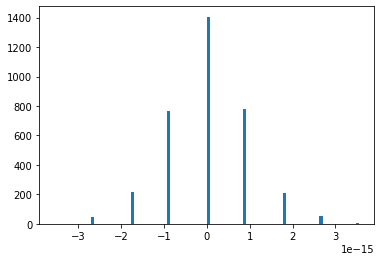

In [9]:
n_atoms = structures.initial_structure.apply(len)
plt.hist(structures["energy"]/n_atoms - structures["energy_per_atom"], bins=100);

MAE 0.04027768846446331


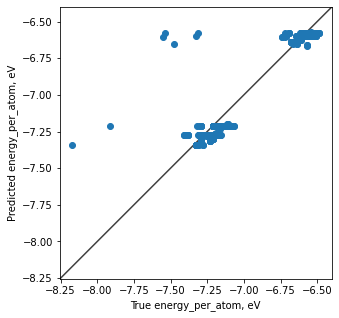

In [17]:
for target, description in checkpoints.items():
  fig, ax = plt.subplots(figsize=(8, 5))
  if description[1] or True:
    ax.scatter(test[target], test.loc[:, f"predicted_{target}"])
    ax.set_xlabel(f"True {target}, eV")
    ax.set_ylabel(f"Predicted {target}, eV")
  else:
    n_atoms = test.initial_structure.apply(len)
    ax.scatter(test[target]/n_atoms, test.loc[:, f"predicted_{target}"]/n_atoms)
    ax.set_xlabel(f"True {target}/atom, eV")
    ax.set_ylabel(f"Predicted {target}/atom, eV")
  lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

  # now plot both limits against eachother
  ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
  ax.set_aspect('equal')
  ax.set_xlim(lims)
  ax.set_ylim(lims);
  print("MAE", np.mean(np.abs(test[target] - test.loc[:, f"predicted_{target}"])))

In [11]:
averaged = test.groupby("descriptor_id").mean()

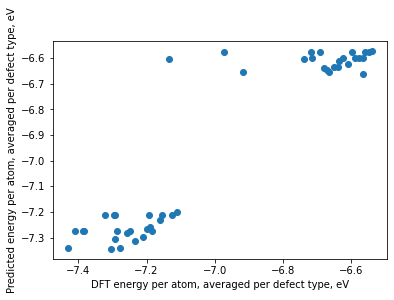

In [12]:
fig, ax = plt.subplots()
ax.scatter(averaged.energy_per_atom, averaged.predicted_energy_per_atom)
ax.set_xlabel("DFT energy per atom, averaged per defect type, eV")
ax.set_ylabel("Predicted energy per atom, averaged per defect type, eV");

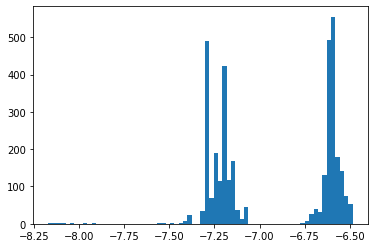

In [13]:
plt.hist(structures.energy_per_atom, bins=70);

In [14]:
import ase.io
def get_gpaw_energies(defect_db_path:str):
    energies = []
    for file_ in os.listdir(defect_db_path):
        if not file_.startswith("id"):
            continue
        this_folder = os.path.join(defect_db_path, file_, "relaxed", "trajectory")
        for traj_file in os.listdir(this_folder):
            try:
              this_structure = ase.io.read(os.path.join(this_folder, traj_file), index="-1")
              energies.append(this_structure.get_potential_energy()/len(this_structure))
            except ase.io.formats.UnknownFileTypeError:
                pass
    return energies

old_dataset = get_gpaw_energies("./datasets/raw_ruslan_202104/new_datasets/defectDB/")

-8.17101564483752


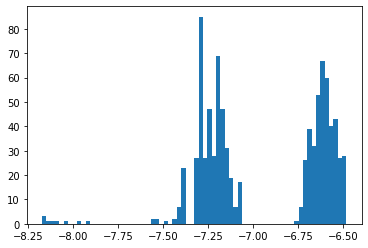

In [15]:
plt.hist(old_dataset, bins=70)
print(min(old_dataset))